In [86]:
from pathlib import Path
from datetime import datetime
import json

EXPERIMENT_FOLDER = f'./experiments/vary_pm/{datetime.now().strftime("%d-%m_%H-%M")}'

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [3]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [4]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [5]:
def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

In [24]:
class MetaExperiment:
    
    def __init__(
        self, 
        p_mutate=0.5,  
        num_experiments=3,
        create_experiment_fn=create_self_play_experiment,
        **make_experiment_kwargs
    ):
        self.p_mutate = p_mutate
        self.num_experiments = num_experiments
        self.experiments = [
            {
                'experiment': create_experiment_fn(
                    p_mutate, **make_experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i in range(num_experiments)
        ]
        for item in self.experiments:
            item['experiment'].print_my_history = item['experiment'].print_history
            item['experiment'].print_history = self.print_history
        
    def print_history(self):
        num_complete = len([
            item for item in self.experiments
            if item['status'] == 'Complete'
        ])
        for item in self.experiments:
            if item['status'] == 'Complete':
                print(f"Results of experiment {item['index']}:")
                item['experiment'].print_test_metrics(item['results'])
        for item in self.experiments:
            if item['status'] == 'In Progress':
                print(f"Running experiment {item['index']}", 
                      f'({num_complete}/{self.num_experiments} complete):')
                item['experiment'].print_my_history()
                break

    def is_finished(self):
        return all([
            item['status'] == 'Complete' 
            for item in self.experiments
        ])
    
    def get_experiment_to_run(self):
        for item in self.experiments:
            if item['status'] == 'In Progress':
                return item
        not_run = [
            item
            for item in self.experiments
            if item['status'] == 'Not Run'
        ]
        if len(not_run) == 0:
            return None
        return not_run[0]
    
    def get_experiment_results(self, experiment):
        test_metrics_items = [
            item['test_metrics']
            for item in experiment.training_history
            if 'test_metrics' in item
        ]
        return test_metrics_items[-1]
    
    def _run_internal(self):
        while not self.is_finished():
            experiment_item = self.get_experiment_to_run()
            index = experiment_item['index']
            experiment = experiment_item['experiment']

            self.experiments[index]['status'] = 'In Progress'

            experiment.run(catch_interrupt=False)

            self.experiments[index]['results'] = \
                self.get_experiment_results(experiment)
            self.experiments[index]['status'] = 'Complete'
    
    def run(self, catch_interrupt=True):
        if catch_interrupt:
            try:
                self._run_internal()
            except KeyboardInterrupt:
                pass
            self._run_internal()
        else:
            self._run_internal()
        
        clear_output()
        self.print_history()
        print('Run Stopped.')

In [22]:
meta_experiment = MetaExperiment(0.3)

In [23]:
meta_experiment.run()

Results of experiment 0:
Test Loss: 1.137, Ground Truth F1-Score: 0.961, Student Error: 0.069, Teacher Error: 0.031, Protocol Diversity: 0.982,
Results of experiment 1:
Test Loss: 1.175, Ground Truth F1-Score: 0.96, Student Error: 0.073, Teacher Error: 0.023, Protocol Diversity: 0.961,
Results of experiment 2:
Test Loss: 1.19, Ground Truth F1-Score: 0.953, Student Error: 0.078, Teacher Error: 0.003, Protocol Diversity: 0.946,
Run Stopped.


In [ ]:
# %tensorboard --logdir logs

In [8]:
from itertools import combinations

def test_game(teacher, student, num_tests=5):
    games_played = []
    for _ in range(num_tests):
        inputs, targets = generate_test_batch()
        outputs = play_game(
            inputs, teacher, student, 
            training=False, 
            p_mutate=0,
        )
        games_played.append((inputs, targets, outputs))
    return games_played


def measure_zero_shot_coordination(meta_experiment):
    results = []
    
    for item_1, item_2 in combinations(meta_experiment.experiments, 2):
        e1 = item_1['experiment']
        e2 = item_2['experiment']
        
        games_played = test_game(e1.teacher, e2.student)
        test_metrics = e1.extract_test_metrics(games_played)
        results.append(test_metrics['mean_ground_truth_f1'])
        
        games_played = test_game(e2.teacher, e1.student)
        test_metrics = e1.extract_test_metrics(games_played)
        results.append(test_metrics['mean_ground_truth_f1'])
    
    return results

In [34]:
measure_zero_shot_coordination(meta_experiment)

[0.9500000000000001, 1.0, 0.65, 1.0, 1.0, 1.0]

In [46]:
class VaryPMutateExperiment(MetaExperiment):
    
    def __init__(self, num_intervals=5, **experiment_kwargs):
        self.num_experiments = num_intervals
        self.experiments = [
            {
                'experiment': MetaExperiment(
                    p_mutate=i/num_intervals, **experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i in range(num_intervals+1)
        ]
        for item_2 in self.experiments:
            for item_2 in item_1['experiment'].experiments:
                item_2['experiment'].print_my_history = item_2['experiment'].print_history
                item_2['experiment'].print_history = self.print_history
            item['experiment'].print_test_metrics = lambda s: self.print_test_metrics(s)
            
    def print_test_metrics(self, experiment):
        for item in self.experiments:
            if item['experiment'] == experiment:
                print('Zero-shot coordination F1-Scores:', item['results'])
                return
    
    def get_experiment_results(self, experiment):
        return measure_zero_shot_coordination(experiment)

In [47]:
vary_pm_experiment = VaryPMutateExperiment()

In [ ]:
vary_pm_experiment.run()

In [148]:
vary_pm_experiment.experiments

[{'experiment': <__main__.MetaExperiment at 0x1fe98878a90>,
  'status': 'Complete',
  'results': [0.34375, 0.41875, 0.36250000000000004, 0.6, 0.2625, 0.26875],
  'index': 0},
 {'experiment': <__main__.MetaExperiment at 0x1fe9896e630>,
  'status': 'Complete',
  'results': [0.85, 0.85625, 0.91875, 0.81875, 0.69375, 0.6625],
  'index': 1},
 {'experiment': <__main__.MetaExperiment at 0x1fe98992080>,
  'status': 'Complete',
  'results': [0.9125, 1.0, 1.0, 1.0, 1.0, 1.0],
  'index': 2},
 {'experiment': <__main__.MetaExperiment at 0x1fe9d47dc88>,
  'status': 'In Progress',
  'results': None,
  'index': 3},
 {'experiment': <__main__.MetaExperiment at 0x1fe9d4a4860>,
  'status': 'Not Run',
  'results': None,
  'index': 4},
 {'experiment': <__main__.MetaExperiment at 0x1fe9d4c6400>,
  'status': 'Not Run',
  'results': None,
  'index': 5}]

In [90]:
[item['experiment'].p_mutate for item in vary_pm_experiment.experiments]

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [153]:
vary_pm_experiment.experiments[0]['experiment'].experiments[0]['experiment'].get_config()

{'max_epochs': 40,
 'steps_per_epoch': 50,
 'epochs_optimised': 40,
 'loss_fn': 'complete_loss_fn',
 'play_params': {'p_mutate': 0.0},
 'test_freq': 5,
 'test_steps': 25,
 'optimiser_config': {'name': 'RMSprop',
  'learning_rate': 0.01,
  'decay': 0.0,
  'rho': 0.9,
  'momentum': 0.0,
  'epsilon': 1e-07,
  'centered': False}}

In [128]:
EXPERIMENT_FOLDER

'./experiments/vary_pm/24-09_09-40'

In [159]:
import simplejson

In [163]:
for item_1 in vary_pm_experiment.experiments:
    if item_1['status'] == 'Complete':
        try:
            meta_exp = item_1['experiment']
            meta_exp_subfolder = \
                f'{EXPERIMENT_FOLDER}/pm={meta_exp.p_mutate}'
            Path(meta_exp_subfolder).mkdir()
            
            experiment_config = \
                meta_exp.experiments[0]['experiment'].get_config()
            meta_data = {
                'index': item_1['index'], 
                'p_mutate': meta_exp.p_mutate,
#                 'experiment_config': experiment_config
            }
            meta_data_path = Path(f'{meta_exp_subfolder}/meta.json')
            with meta_data_path.open(mode='w') as f:
                json.dump(meta_data, f)
            
            results = {
                'zs_coord_f1_scores': item_1['results']
            }
            results_path = Path(f'{meta_exp_subfolder}/results.json')
            with results_path.open(mode='w') as f:
                simplejson.dump(results, f)
            
            for item_2 in meta_exp.experiments:
                logs_file_loc = \
                    f"{meta_exp_subfolder}/experiment_{item_2['index']}_logs.json"
                logs_file_path = Path(logs_file_loc)
                
                with logs_file_path.open(mode='w') as f:
                    json.dump(item_2['experiment'].training_history, f)
            
            print('Saved experiment data at:', meta_exp_subfolder)
        except FileExistsError:
            print('Experiment', item_1['index'], 'already saved.')

Experiment 0 already saved.
Experiment 1 already saved.
Saved experiment data at: ./experiments/vary_pm/24-09_09-40/pm=0.4


In [164]:
df = pd.DataFrame([
    {
        'Mutation Probability': item['experiment'].p_mutate,
        'Zero-Shot Coordination Score': score,
    }
    for item in vary_pm_experiment.experiments
    if item['status'] == 'Complete'
    for score in item['results']
])

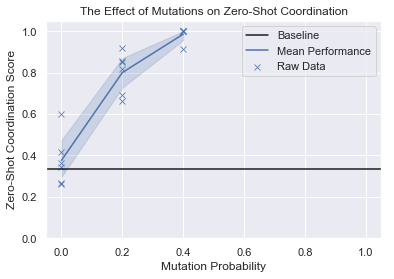

In [169]:
sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], dashes=True, color=(0.1, 0.1, 0.1), label='Baseline')
sns.lineplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, label='Mean Performance')
sns.scatterplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, marker='x', label='Raw Data')
plt.ylim([0, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Zero-Shot Coordination')
plt.show()